# Powerless in Maryland
##  Supervised Machine Learning Final Project for DTSA 5509
Prepared by Ryan Birmingham

# Introduction
## About The Data
I found a dataset for power outages in the state of Maryland by zipcode from the Data.gov website,  https://catalog.data.gov/dataset/power-outages-zipcode

I'm curious if there's any connection between this and any other avaliable social sciences zipcode data, and what the nature of that connection may be.

I found some zipcode data at https://catalog.data.gov/dataset/zip-code-data, and downloaded for 2010 for Maryland.

## Initial Hypotheses

I suspect to see some kind of pattern, but am unsure of what the pattern may be. We may see econmic centers lose power less often due to investment or priorities. We may also see wealthy residential areas lose power more often due to political power associated with wealthy constituients.
Also, it's quite possible that the pattern is geospatial more than social. I suspect there will be some component of that as error when using social metrics exclusively, but we'll have to see what is required.

## About the Models
Since we have a supervised dataset, this is a regression task. Also, we can interpret the data as categorical after buckets. Later in the report, I'll compare these different methods and approaches within them by their performance and limitations.

# Working with the Data
## Cleaning and Formatting
Looking at each of the data, we got lucky on one but not the other. The power outage data is easily machine-readable. However, the zipcode data is geared for a human exclusively. Before we can do EDA and interpret the zipcode social data, we need to transform it.

In [1]:
! ls data

10zp21md.csv  20zp21md.xlsx	md_zip_econ_2010.csv
10zp21md.xls  MdZipDataRaw.png	Power_Outages_-_Zipcode.csv


In [2]:
! head data/Power_Outages_-_Zipcode.csv

uid,area,outages,dt_stamp
206182023-04-01T17:15:37,20618,1,04/01/2023 05:15:37 PM
206392023-04-01T17:15:37,20639,1,04/01/2023 05:15:37 PM
206782023-04-01T17:15:37,20678,6,04/01/2023 05:15:37 PM
206932023-04-01T17:15:37,20693,2,04/01/2023 05:15:37 PM
208542023-04-01T17:15:37,20854,6,04/01/2023 05:15:37 PM
208552023-04-01T17:15:37,20855,4,04/01/2023 05:15:37 PM
210132023-04-01T17:15:37,21013,90,04/01/2023 05:15:37 PM
210372023-04-01T17:15:37,21037,4,04/01/2023 05:15:37 PM
210472023-04-01T17:15:37,21047,28,04/01/2023 05:15:37 PM


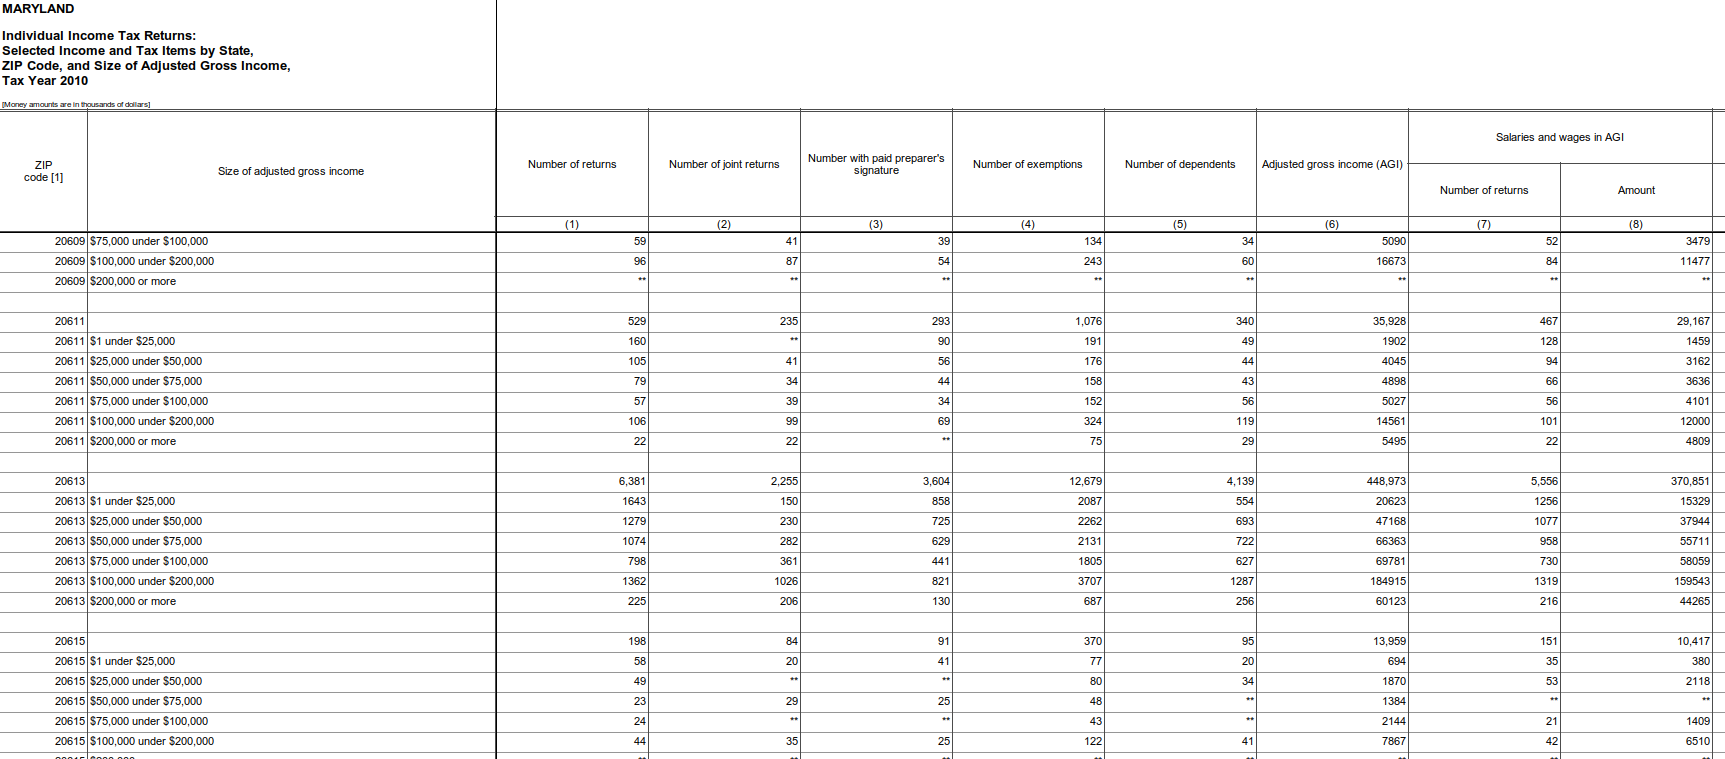

In [3]:
from IPython.display import Image
Image(filename='data/MdZipDataRaw.png') 

Luckily, there's a pattern in the data. There's a header row, and the rows with summary data have a non-blank zipcode but a blank "Size of adjusted gross income". However, some of the things here aren't playing nice with the XLS libraries, so I've manually recreated this data in a format which pandas can understand.

There are also some notes in the zip data which may cause systematic error, namely:

"The ZIP Code is based on the 5-digit ZIP code on the individual  income tax return.  ZIP Codes with less than 100 returns,  identified as a single building ZIP code, or identified as a  nonresidential ZIP code have been omitted from the data."



In [4]:
! head data/md_zip_econ_2010.csv

I know from having processed this data that:
 * zip should be treated as categorical, as if a string. All other columns are associated with their zip.
 * returns is the number of returns
 * joint returns is the number of joint returns
 * prepared_returns is the number of returns where a paid preparer signed off on them
 * excemptions is the total excemption count
 * dependents is the total dependent count
 * AGI is the total AGI for the zip
 * business income is the total "business income" in non-business returns
 * farm_returns is the number of returns designated as farm
 * num_unemployment is the number of returns including unemployment
 * taxes_paid is the amount of tax paid federally
 * num_mortgage is the number of returns with any mortgage interest deducted
 * num_energy_credit is the number of returns with a "Residential energy credit"
 * energy_credit is the total of the "Residential energy credit"

Anyway, let's get them into dataframes so we can inspect them numerically.

In [5]:
import pandas as pd

In [6]:
taxes = pd.read_csv('data/md_zip_econ_2010.csv')
outages = pd.read_csv('data/Power_Outages_-_Zipcode.csv')

In [7]:
print(taxes.info)
print(outages.info)

<bound method DataFrame.info of        zip  returns  joint_returns  prepared_returns  exemptions  dependents  \
0    20601    11650           4108              6055       23650        8073   
1    20602    11594           3242              6042       23265        8402   
2    20603    13077           4785              6419       27659       10243   
3    20606      154             74                87         300          78   
4    20607     5028           1939              2621       10184        3300   
..     ...      ...            ...               ...         ...         ...   
400  21915     1519            734               847        3225         882   
401  21917     1177            606               630        2483         769   
402  21918     1991            931              1023        4060        1218   
403  21919     1313            650               777        2632         731   
404  21921    18666           7742              9792       38464       12564   

       

The target variable should be the number of outages. How do those look?

In [8]:
import matplotlib.pyplot as plt

(array([6.5243e+04, 1.2200e+02, 1.4000e+01, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1.00000e+00, 1.39120e+03, 2.78140e+03, 4.17160e+03, 5.56180e+03,
        6.95200e+03, 8.34220e+03, 9.73240e+03, 1.11226e+04, 1.25128e+04,
        1.39030e+04]),
 <BarContainer object of 10 artists>)

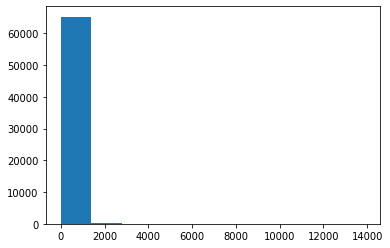

In [9]:
plt.hist(outages['outages'])

Hm, it looks like we may have a substantial outlier. What's that?

In [10]:
outages[outages['outages']>1000]

,uid,area,outages,dt_stamp
1294,207212023-04-01T19:00:33,20721,2484,04/01/2023 07:00:33 PM
1887,207852023-04-02T06:30:33,20785,1189,04/02/2023 06:30:33 AM
2026,207212023-04-01T19:15:38,20721,1755,04/01/2023 07:15:38 PM
2423,217022023-04-01T19:15:38,21702,1199,04/01/2023 07:15:38 PM
2744,206012023-04-01T19:30:32,20601,1209,04/01/2023 07:30:32 PM
...,...,...,...,...
64341,211582023-04-12T19:45:35,21158,2947,04/12/2023 07:45:35 PM
64366,211572023-04-12T20:00:38,21157,11090,04/12/2023 08:00:38 PM
64367,211582023-04-12T20:00:38,21158,2945,04/12/2023 08:00:38 PM
64391,211572023-04-12T20:15:35,21157,8655,04/12/2023 08:15:35 PM


We'd better see what can be done with those dates.

(array([ 3860.,  2901.,  2937.,  3004., 24100., 10485.,  7796.,  3277.,
         3006.,  4022.]),
 array([19439.74012731, 19441.83907292, 19443.93801852, 19446.03696412,
        19448.13590972, 19450.23485532, 19452.33380093, 19454.43274653,
        19456.53169213, 19458.63063773, 19460.72958333]),
 <BarContainer object of 10 artists>)

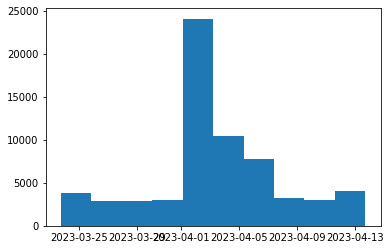

In [12]:
plt.hist(outages['dt_stamp'].astype("datetime64"))

I'm not doing anything for the time series data, let's flatten time data and explore that.

In [22]:
outage_data = outages.groupby('area').agg({'outages':'sum'})

In [23]:
outage_data

,outages
area,
20601,18048
20602,1115
20603,8421
20604,45
20606,5053
...,...
21915,136
21917,1073
21918,13399


In [24]:
outage_data.columns

Index(['outages'], dtype='object')

In [28]:
outage_data['outages']

area
20601    18048
20602     1115
20603     8421
20604       45
20606     5053
         ...  
21915      136
21917     1073
21918    13399
21919       77
21921    20257
Name: outages, Length: 412, dtype: int64

In [29]:
outage_data.reset_index(inplace=True)
outage_data

,area,outages
0,20601,18048
1,20602,1115
2,20603,8421
3,20604,45
4,20606,5053
...,...,...
407,21915,136
408,21917,1073
409,21918,13399
410,21919,77


(array([330.,  42.,  18.,  12.,   6.,   0.,   1.,   0.,   2.,   1.]),
 array([1.00000e+00, 9.76470e+03, 1.95284e+04, 2.92921e+04, 3.90558e+04,
        4.88195e+04, 5.85832e+04, 6.83469e+04, 7.81106e+04, 8.78743e+04,
        9.76380e+04]),
 <BarContainer object of 10 artists>)

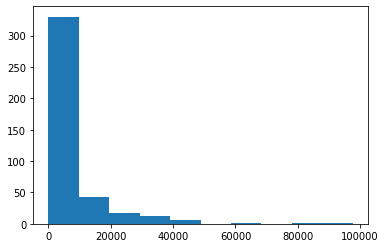

In [30]:
plt.hist(outage_data['outages'])

That's much closer to what we need. We can set the index back later to join.
Anyway, what are our "outliers" here?

In [31]:
outage_data[outage_data['outages'] > 80000]

,area,outages
182,21078,81044
197,21122,97638
211,21157,82812


Due to the magic of google, I can see that these are Havre de Grace, a group of towns including Pasadena, and Westminster. Nothing seems especially noteworthy?

Anyway, exploring the hists for the tax data.

(array([281.,  81.,  23.,  14.,   2.,   2.,   1.,   0.,   0.,   1.]),
 array([2.4590000e+03, 5.5924930e+05, 1.1160396e+06, 1.6728299e+06,
        2.2296202e+06, 2.7864105e+06, 3.3432008e+06, 3.8999911e+06,
        4.4567814e+06, 5.0135717e+06, 5.5703620e+06]),
 <BarContainer object of 10 artists>)

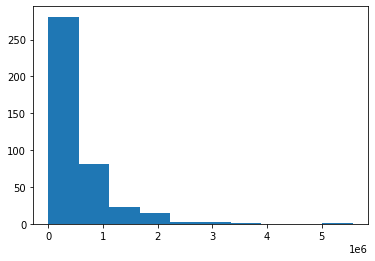

In [32]:
plt.hist(taxes['agi'])

(array([246.,  59.,  54.,  23.,  14.,   5.,   0.,   3.,   0.,   1.]),
 array([   0. ,  346.8,  693.6, 1040.4, 1387.2, 1734. , 2080.8, 2427.6,
        2774.4, 3121.2, 3468. ]),
 <BarContainer object of 10 artists>)

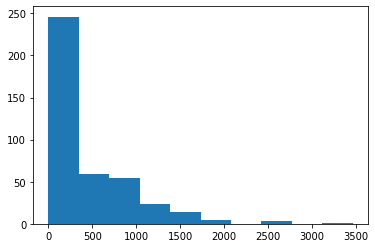

In [33]:
plt.hist(taxes['energy_credit'])

(array([217.,  63.,  35.,  41.,  19.,  16.,   7.,   3.,   1.,   3.]),
 array([   0. ,  263.5,  527. ,  790.5, 1054. , 1317.5, 1581. , 1844.5,
        2108. , 2371.5, 2635. ]),
 <BarContainer object of 10 artists>)

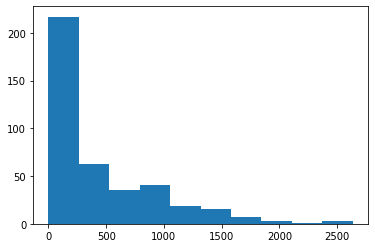

In [34]:
plt.hist(taxes['num_energy_credit'])

(array([211.,  54.,  30.,  34.,  29.,  23.,  13.,   6.,   3.,   2.]),
 array([   93.,  3564.,  7035., 10506., 13977., 17448., 20919., 24390.,
        27861., 31332., 34803.]),
 <BarContainer object of 10 artists>)

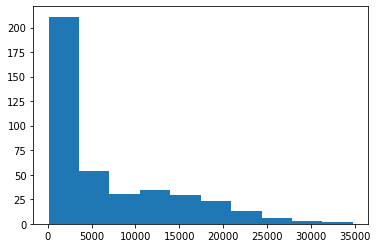

In [35]:
plt.hist(taxes['returns'])

# Data: Joining and Correlation Analysis
We really want one dataset with zip, power outage, and the taxes info together. Also, we want to see any initial correlations between these fields.


In [45]:
# setting indexes
taxes.set_index('zip')
outage_data.set_index('area')
# joining
data = taxes.join(outage_data)
data.drop(['area'], axis=1, inplace=True)
print(data.shape)
data.head()


(405, 15)


,zip,returns,joint_returns,prepared_returns,exemptions,dependents,agi,business_income,farm_returns,num_unemployment,taxes_paid,num_mortgage,num_energy_credit,energy_credit,outages
0,20601,11650,4108,6055,23650,8073,758051,5787,34,734,58408,5438,968,899,18048
1,20602,11594,3242,6042,23265,8402,639590,822,0,791,44521,4885,929,848,1115
2,20603,13077,4785,6419,27659,10243,959395,3965,0,770,75932,6669,1085,1012,8421
3,20606,154,74,87,300,78,9375,367,0,0,723,54,0,0,45
4,20607,5028,1939,2621,10184,3300,411954,1740,0,315,38741,2778,415,460,5053


In [48]:
import seaborn as sb

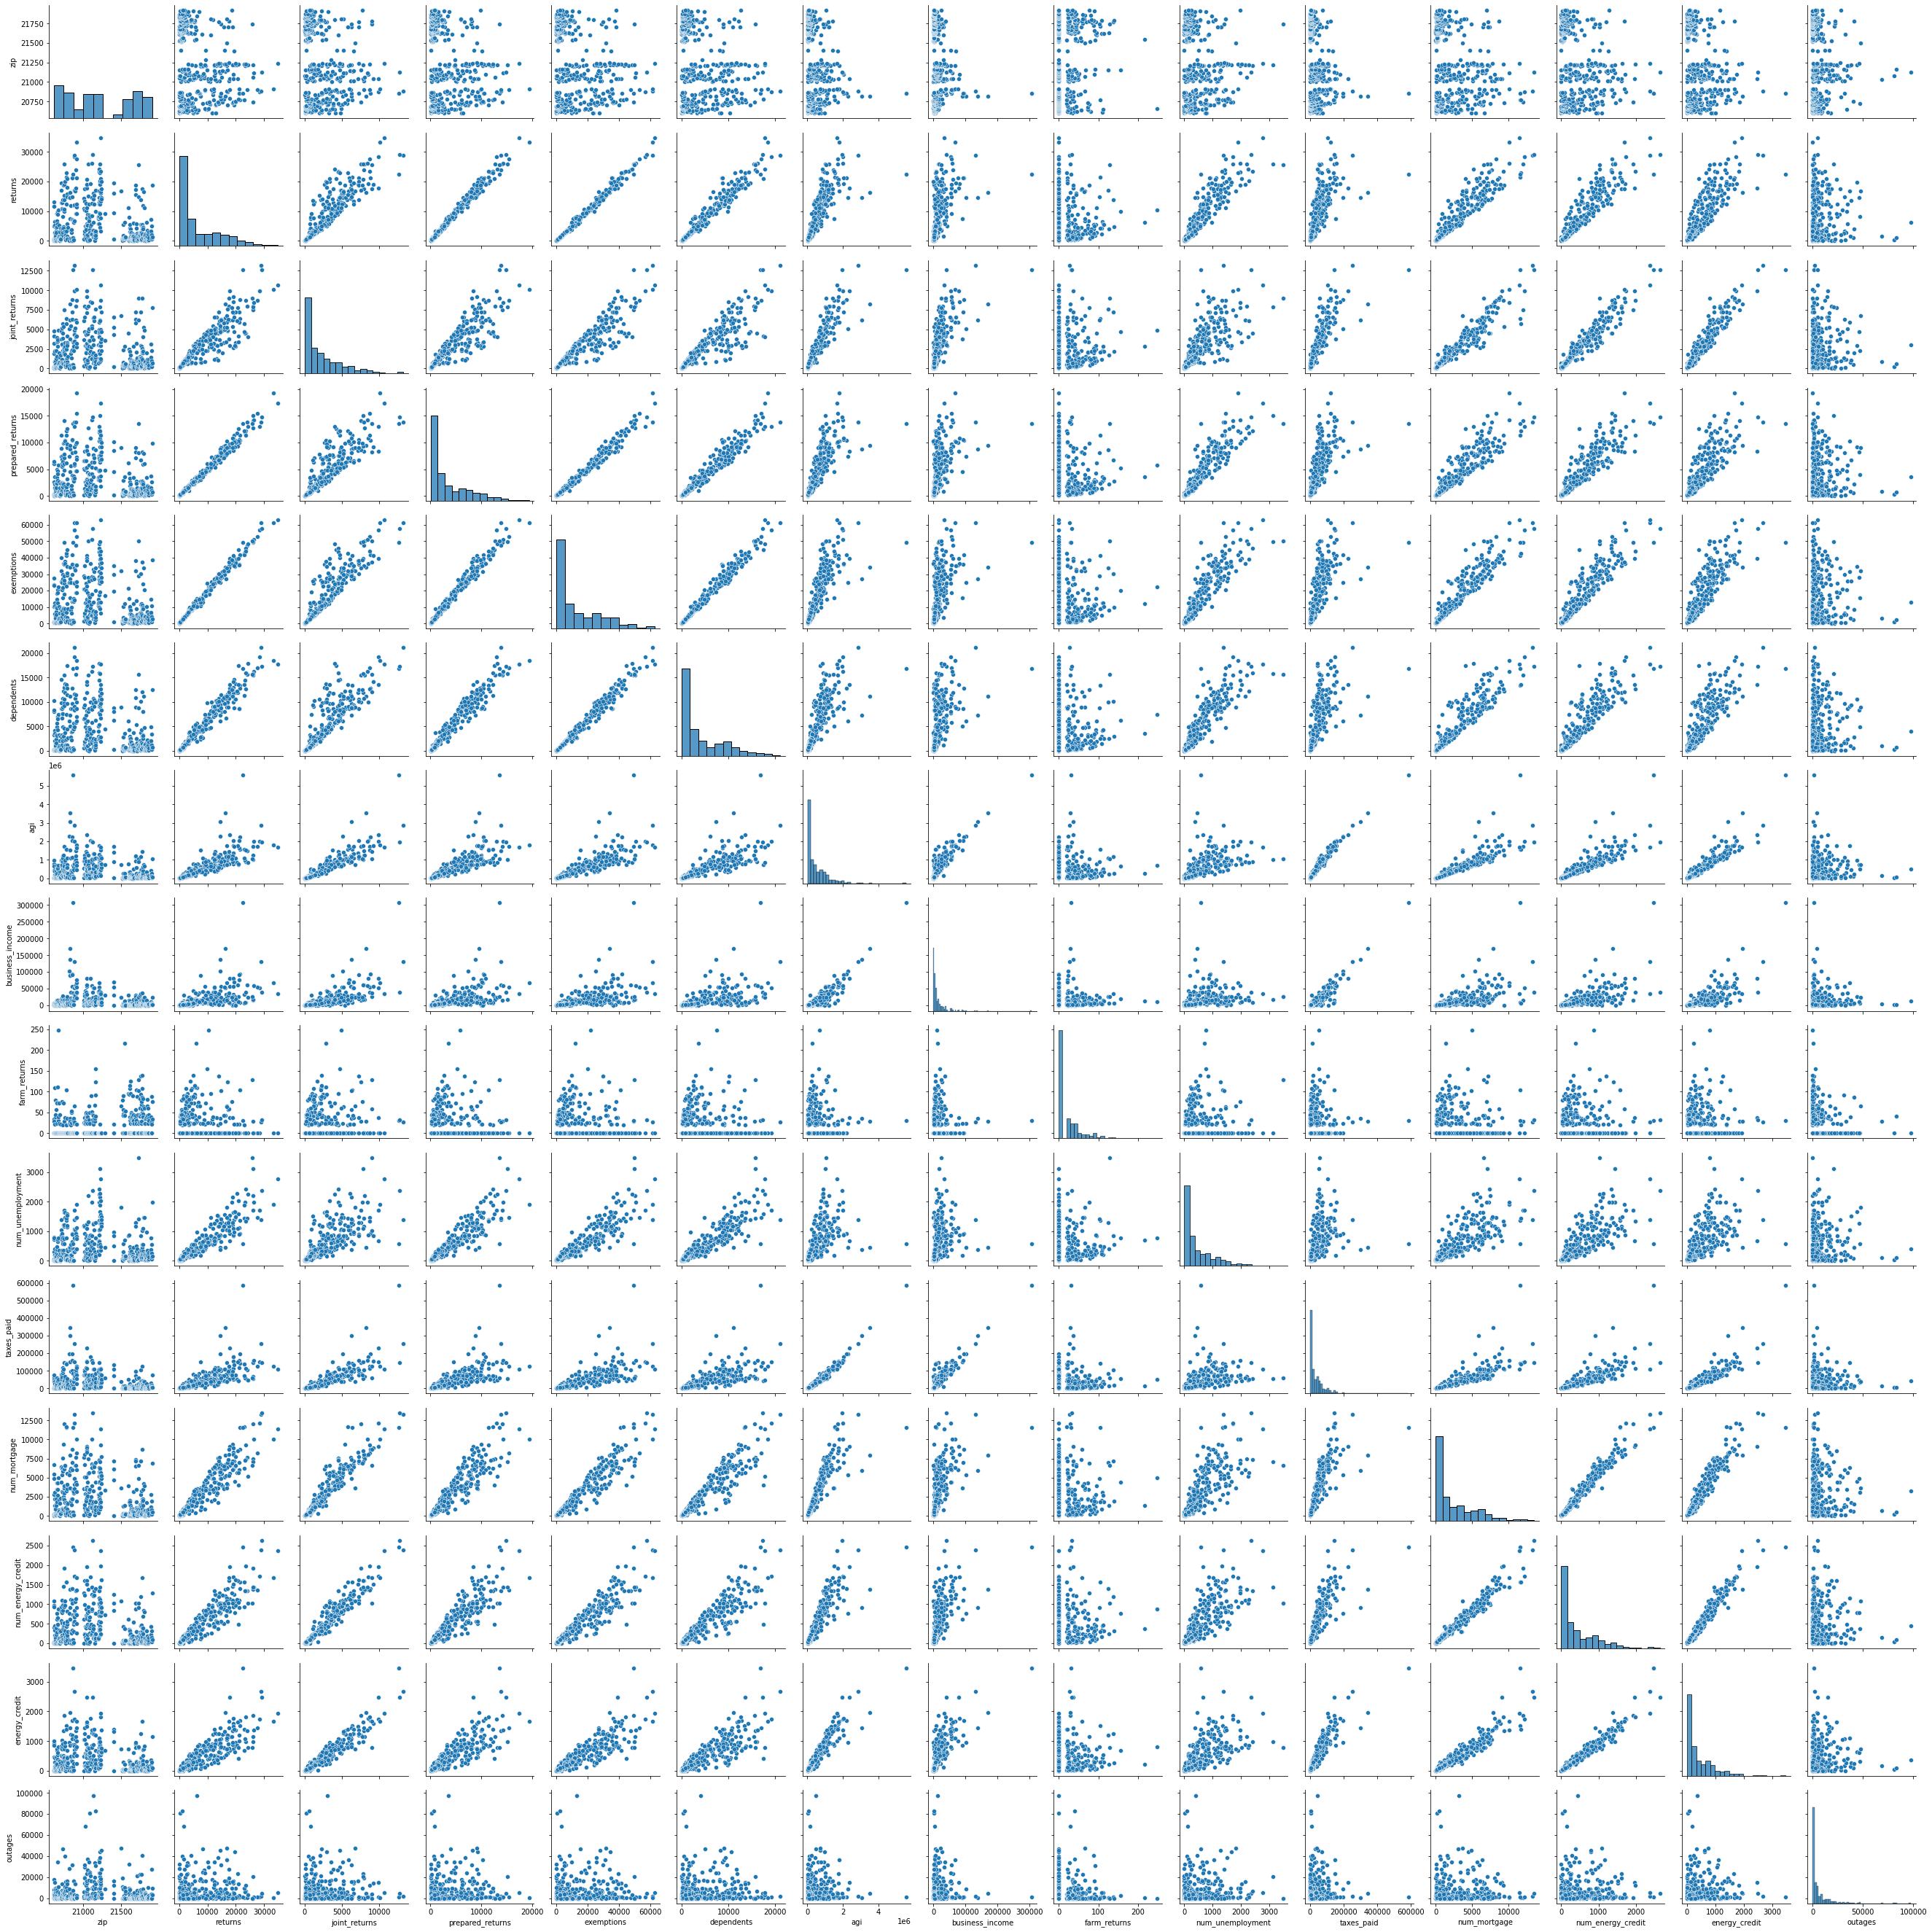

In [49]:
sb.pairplot(data)

In [50]:
data.corr()

,zip,returns,joint_returns,prepared_returns,exemptions,dependents,agi,business_income,farm_returns,num_unemployment,taxes_paid,num_mortgage,num_energy_credit,energy_credit,outages
zip,1.000000,-0.230656,-0.187477,-0.230673,-0.234985,-0.252256,-0.247952,-0.159201,0.246737,-0.103103,-0.245697,-0.258970,-0.224541,-0.239739,-0.075288
returns,-0.230656,1.000000,0.913035,0.993851,0.996481,0.979532,0.823908,0.557539,-0.028285,0.920223,0.714051,0.942262,0.926402,0.866784,0.060013
joint_returns,-0.187477,0.913035,1.000000,0.901304,0.926719,0.899779,0.899170,0.702435,0.097629,0.771018,0.831098,0.956189,0.966380,0.956986,0.050164
prepared_returns,-0.230673,0.993851,0.901304,1.000000,0.990802,0.975890,0.823559,0.571085,-0.020110,0.919301,0.716637,0.926571,0.911075,0.854345,0.055922
exemptions,-0.234985,0.996481,0.926719,0.990802,1.000000,0.991010,0.834031,0.572312,-0.015625,0.911664,0.729787,0.949770,0.935201,0.881348,0.055159
dependents,-0.252256,0.979532,0.899779,0.975890,0.991010,1.000000,0.808671,0.545111,-0.025867,0.900946,0.708434,0.931602,0.912410,0.858878,0.045602
agi,-0.247952,0.823908,0.899170,0.823559,0.834031,0.808671,1.000000,0.896617,-0.004715,0.605254,0.981965,0.883412,0.884075,0.940064,0.033093
business_income,-0.159201,0.557539,0.702435,0.571085,0.572312,0.545111,0.896617,1.000000,0.005655,0.313408,0.930913,0.616852,0.643435,0.762190,0.016940
farm_returns,0.246737,-0.028285,0.097629,-0.020110,-0.015625,-0.025867,-0.004715,0.005655,1.000000,0.033704,0.005601,0.014844,0.031931,0.036843,-0.085087
num_unemployment,-0.103103,0.920223,0.771018,0.919301,0.911664,0.900946,0.605254,0.313408,0.033704,1.000000,0.468848,0.795969,0.790995,0.676071,0.074895


## Analysis on Correlations
outages does not have very strong correlations with other fields, which will likely be an issue going forward.
Also, it makes sense that some of the largest correlations are between the tax fields, as both have a hidden population influence.

# Models
Let's compare performance between a few different regression models.

In [60]:
# classic, ols
import numpy as np
from sklearn.linear_model import LinearRegression
# does using another kind of metric such as in elastic net perform especially differently than ols?
from sklearn.linear_model import ElasticNet
# includes a kernel trick, may be useful!
from sklearn.kernel_ridge import KernelRidge


In [54]:
# let's also prepare a data split ahead of time.
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)

In [66]:
# univariate, just our closest population metric
X = train['returns'].to_numpy().reshape(-1, 1)
y = train['outages'].to_numpy().reshape(-1, 1)
# ols
ols1 = LinearRegression()
ols1.fit(X,y)
print("LinearRegression score", ols1.score(X,y))
print("LinearRegression coefficient", ols1.coef_)
print("LinearRegression intercept", ols1.intercept_)
# "elastic net"
en1 = ElasticNet()
en1.fit(X,y)
print("ElasticNet score", en1.score(X,y))
print("ElasticNet coefficient", en1.coef_)
print("ElasticNet intercept", en1.intercept_)
# "kernel ridge"
kr1 = KernelRidge()
kr1.fit(X,y)
print("KernelRidge score", kr1.score(X,y))
# kernel ridge does not have coefficients or intercept.

LinearRegression score 0.007546531998405603
LinearRegression coefficient [[0.12969874]]
LinearRegression intercept [5535.84088481]
ElasticNet score 0.007546531998405381
ElasticNet coefficient [0.12969872]
ElasticNet intercept [5535.84095476]
KernelRidge score -0.12863741621230496


In [ ]:
# A few hand-picked features.
# univariate, just our closest population metric
X = train['returns'].to_numpy().reshape(-1, 1)
y = train['outages'].to_numpy().reshape(-1, 1)
# ols
ols1 = LinearRegression()
ols1.fit(X,y)
print("LinearRegression score", ols1.score(X,y))
print("LinearRegression coefficient", ols1.coef_)
print("LinearRegression intercept", ols1.intercept_)
# "elastic net"
en1 = ElasticNet()
en1.fit(X,y)
print("ElasticNet score", en1.score(X,y))
print("ElasticNet coefficient", en1.coef_)
print("ElasticNet intercept", en1.intercept_)
# "kernel ridge"
kr1 = KernelRidge()
kr1.fit(X,y)
print("KernelRidge score", kr1.score(X,y))
# kernel ridge does not have coefficients or intercept.

In [70]:
train[['returns','energy_credit','farm_returns', 'agi']]

,returns,energy_credit,farm_returns,agi
302,440,21,31,19670
274,173,0,0,9139
151,17577,1452,0,1246342
36,1341,85,39,91161
138,17788,1164,0,1209593
...,...,...,...,...
281,790,45,30,41760
388,287,17,0,11910
94,1589,291,35,131184
374,262,0,0,9019


In [71]:
# A few hand-picked features.
# univariate, just our closest population metric
X = train[['returns','energy_credit','farm_returns', 'agi']].to_numpy()
y = train['outages'].to_numpy().reshape(-1, 1)
# ols
ols2 = LinearRegression()
ols2.fit(X,y)
print("LinearRegression score", ols2.score(X,y))
print("LinearRegression coefficient", ols2.coef_)
print("LinearRegression intercept", ols2.intercept_)
# "elastic net"
en2 = ElasticNet()
en2.fit(X,y)
print("ElasticNet score", en2.score(X,y))
print("ElasticNet coefficient", en2.coef_)
print("ElasticNet intercept", en2.intercept_)
# "kernel ridge"
kr2 = KernelRidge()
kr2.fit(X,y)
print("KernelRidge score", kr2.score(X,y))
# kernel ridge does not have coefficients or intercept.

LinearRegression score 0.020867044425793013
LinearRegression coefficient [[ 1.82208219e-01  8.70587750e-01 -3.34043245e+01 -1.61348360e-03]]
LinearRegression intercept [6357.74595388]
ElasticNet score 0.02086704250410909
ElasticNet coefficient [ 1.82224789e-01  8.70013581e-01 -3.33906957e+01 -1.61320402e-03]
ElasticNet intercept [6357.42285073]
KernelRidge score -0.12322924507630728


## Trying a Clustering/Categorical Approach
So, the data performs poorly under linear and nonlinear regression. Can we instead see if any fields would be useful for a nearest neighbors algorithm (not spatially).

Let's split the outages into lograthmic buckets.

(array([326.,  41.,  16.,  12.,   6.,   0.,   1.,   0.,   2.,   1.]),
 array([1.00000e+00, 9.76470e+03, 1.95284e+04, 2.92921e+04, 3.90558e+04,
        4.88195e+04, 5.85832e+04, 6.83469e+04, 7.81106e+04, 8.78743e+04,
        9.76380e+04]),
 <BarContainer object of 10 artists>)

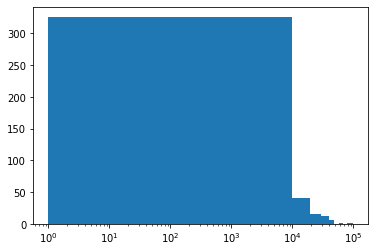

In [74]:
plt.xscale('log')
plt.hist(data['outages'])


In [78]:
import math
data['outage_risk'] = data['outages'].apply(lambda x: math.floor(math.log10(x)))

(array([ 12.,   0.,  46.,   0.,   0.,  98.,   0., 172.,   0.,  77.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

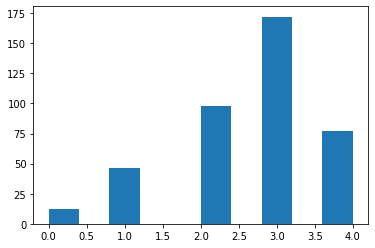

In [79]:
plt.hist(data['outage_risk'])

In [80]:
train, test = train_test_split(data, test_size=0.2)

In [87]:
from sklearn.neighbors import KNeighborsClassifier

X = train[['returns','energy_credit','farm_returns', 'agi']].to_numpy()
y = train['outage_risk'].to_numpy().reshape(-1, 1)

X_test = test[['returns','energy_credit','farm_returns', 'agi']].to_numpy()
y_test = test['outage_risk'].to_numpy().reshape(-1, 1)

n3 = KNeighborsClassifier(n_neighbors=3)
n3.fit(X,y)
print("3 neighbor train score", n3.score(X,y))
print("3 neighbor test score", n3.score(X_test,y_test))

3 neighbor train score 0.5987654320987654
3 neighbor test score 0.1728395061728395


/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [91]:
#hyperparameter tuning, 0 to 100, keep track of scores, plot
train_scores = []
test_scores = []
neighbors = [x for x in range(1,101)]
for i in neighbors:
    nn = KNeighborsClassifier(n_neighbors=i)
    nn.fit(X,y)
    train_scores.append(nn.score(X,y))
    test_scores.append(nn.score(X_test,y_test))


/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

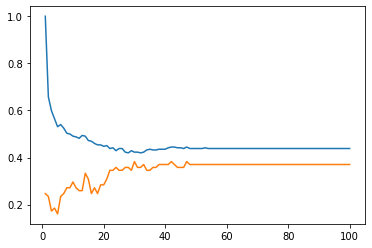

In [92]:
    
plt.plot(neighbors, train_scores, label="train")
plt.plot(neighbors, test_scores, label="test")

# Analysis of Results

All regression results were not very good. However, we did get better results with neighbor clustering. Let's look at confusion for the knn model.

In [99]:
from sklearn.metrics import confusion_matrix

X = train[['returns','energy_credit','farm_returns', 'agi']].to_numpy()
y = train['outage_risk'].to_numpy().reshape(-1, 1)
X_test = test[['returns','energy_credit','farm_returns', 'agi']].to_numpy()
y_test = test['outage_risk'].to_numpy().reshape(-1, 1)
n3 = KNeighborsClassifier(n_neighbors=20)
n3.fit(X,y)
yhat = n3.predict(X)

confusion_matrix(y, yhat)

/home/ryan/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([[  0,   0,   3,   7,   1],
       [  0,   3,  11,  22,   1],
       [  0,   4,  13,  58,   2],
       [  0,   4,  11, 124,   3],
       [  0,   4,   3,  45,   5]])

# Discussion and Conclusion 

I picked a difficult task. The connections between social data via taxes and power outages is much more subtle than correlations between other features. Nonetheless, we are able to us k-nearest-neighbors among some selected fields to determine the overall risk of power outages.
However, there is much more work to do. Use of unsupervised approaches may help determine other kinds of patterns which ols/ridge/kernel regression or neighbor regression fail to do.